C:\Users\zboro\AppData\Local\Temp\ipykernel_23428\2100802648.py:58: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return df.replace(mapping).fillna(0)


Rozpoczęcie treningu...
Epoch 1/3000, Train Loss: 0.0332, Val Loss: 0.0161, Train R²: -1.8731, Val R²: -0.1066
Epoch 2/3000, Train Loss: 0.0152, Val Loss: 0.0083, Train R²: -0.1375, Val R²: 0.4476
Epoch 3/3000, Train Loss: 0.0087, Val Loss: 0.0056, Train R²: 0.2539, Val R²: 0.6306
Epoch 4/3000, Train Loss: 0.0066, Val Loss: 0.0066, Train R²: 0.4264, Val R²: 0.5507
Epoch 5/3000, Train Loss: 0.0068, Val Loss: 0.0039, Train R²: 0.4191, Val R²: 0.7409
Epoch 6/3000, Train Loss: 0.0052, Val Loss: 0.0039, Train R²: 0.5498, Val R²: 0.7433
Epoch 7/3000, Train Loss: 0.0053, Val Loss: 0.0034, Train R²: 0.5447, Val R²: 0.7727
Epoch 8/3000, Train Loss: 0.0048, Val Loss: 0.0036, Train R²: 0.6056, Val R²: 0.7648
Epoch 9/3000, Train Loss: 0.0046, Val Loss: 0.0034, Train R²: 0.6024, Val R²: 0.7778
Epoch 10/3000, Train Loss: 0.0047, Val Loss: 0.0037, Train R²: 0.5960, Val R²: 0.7578
Epoch 11/3000, Train Loss: 0.0041, Val Loss: 0.0035, Train R²: 0.6512, Val R²: 0.7720
Epoch 12/3000, Train Loss: 0.0041, V

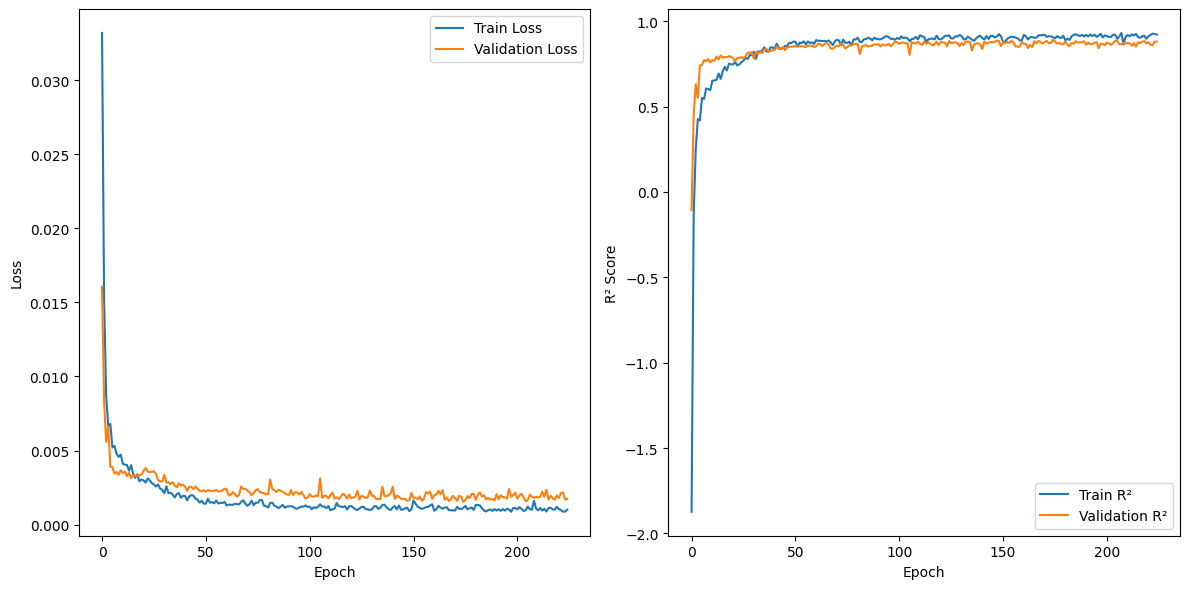


                 Metryki końcowe                  
Zbiór           | MSE        | RSE        | R²        
--------------------------------------------------
Treningowy      | 272944704.00 | 0.0443     | 0.9557    
Walidacyjny     | 757781888.00 | 0.1097     | 0.8903    
Testowy         | 4671389294.07 | 17.1322    | -16.1322  

Zapisano przewidywania do pliku submission_improved.csv


In [23]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os

# ==============================================
# HIPERPARAMETRY
# ==============================================
config = {
    "batch_size": 64,
    "learning_rate": 0.002,
    "epochs": 3000,
    "early_stopping_patience": 50,
    "hidden_layers": [128, 64, 32],  # Warstwy ukryte
    "dropout_rate": 0.2,
    "use_dropout": True,
    "validation_size": 0.2,
    "random_state": 0,
}

# ==============================================
# FUNKCJE POMOCNICZE
# ==============================================
def load_data():
    train_df = pd.read_csv("Data/train.csv")
    test_df = pd.read_csv("Data/test.csv")
    return train_df, test_df

def preprocess_data(train_df, test_df):
    # Usuwanie kolumn z brakującymi wartościami (>50%)
    missing_values_train = train_df.isnull().sum() / len(train_df) * 100
    missing_values_test = test_df.isnull().sum() / len(test_df) * 100
    
    cols_to_drop = set(missing_values_train[missing_values_train > 50].index)
    cols_to_drop.update({'Id', 'LandContour', 'LotConfig', 'LotFrontage', 'Street', 'LotShape', 'LandSlope', 'YearBuilt', 'RoofStyle', 'RoofMatl', 
                         'Exterior1st', 'Exterior2nd', 'MasVnrArea', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 
                         'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 
                         'Electrical', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 
                         'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageCars', 'PavedDrive', 'WoodDeckSF', 
                         '3SsnPorch', 'PoolArea', 'MiscVal', 'MoSold', 'SaleType', 'SaleCondition', 'Condition1', 'Condition2','HouseStyle'})

    train_df.drop(columns=cols_to_drop, inplace=True)
    test_df.drop(columns=cols_to_drop - {'SalePrice'}, inplace=True)  # SalePrice nie ma w test_df

    # Kodowanie jakości
    def encode_quality_df(df):
        mapping = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0, 
                   'AllPub': 3, 'NoSewr': 2, 'NoSeWa': 1, 'ELO': 0, 
                   'N': 0, 'Y': 1, 'Fin': 3, 'RFn': 2, 'Unf': 1, 
                   'Typ': 5, 'Min1': 4, 'Min2': 4, 'Mod': 3, 'Maj1': 2, 'Maj2': 2, 'Sev': 1, 'Sal': 0}
        return df.replace(mapping).fillna(0)

    train_df = encode_quality_df(train_df)
    test_df = encode_quality_df(test_df)

    # One-hot encoding
    for col in ['MSZoning', 'BldgType', 'Neighborhood', 'MSSubClass']:
        train_df = pd.get_dummies(train_df, columns=[col], dtype=int)
        test_df = pd.get_dummies(test_df, columns=[col], dtype=int)
        # Dodaj brakujące kolumny w test_df
        missing_cols = set(train_df.columns) - set(test_df.columns)
        for c in missing_cols:
            if c.startswith(col + '_'):
                test_df[c] = 0

    # Upewnij się, że kolumny są takie same
    test_df = test_df[train_df.drop('SalePrice', axis=1, errors='ignore').columns]

    return train_df, test_df

# ==============================================
# MODEL SIECI NEURONOWEJ
# ==============================================
class HousePriceModel(nn.Module):
    def __init__(self, input_dim, hidden_layers, dropout_rate=0.2, use_dropout=True):
        super(HousePriceModel, self).__init__()
        layers = []
        prev_layer = input_dim
        
        for layer_size in hidden_layers:
            layers.append(nn.Linear(prev_layer, layer_size))
            layers.append(nn.ReLU())
            if use_dropout:
                layers.append(nn.Dropout(dropout_rate))
            prev_layer = layer_size
        
        layers.append(nn.Linear(prev_layer, 1))
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(x)

# ==============================================
# TRENING MODELU (zmodyfikowana funkcja)
# ==============================================
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs, patience):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    train_losses = []
    val_losses = []
    train_r2 = []
    val_r2 = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        all_preds = []
        all_true = []
        
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            # Zbieranie predykcji dla R²
            all_preds.extend(outputs.detach().numpy())
            all_true.extend(batch_y.numpy())
        
        # Oblicz R² dla treningu
        train_r2_score = r2_score(all_true, all_preds)
        train_r2.append(train_r2_score)
        
        # Walidacja
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_true = []
        with torch.no_grad():
            for val_X, val_y in val_loader:
                val_outputs = model(val_X)
                v_loss = criterion(val_outputs, val_y)
                val_loss += v_loss.item()
                val_preds.extend(val_outputs.numpy())
                val_true.extend(val_y.numpy())
        
        # Oblicz R² dla walidacji
        val_r2_score = r2_score(val_true, val_preds)
        val_r2.append(val_r2_score)
        
        epoch_train_loss = running_loss / len(train_loader)
        epoch_val_loss = val_loss / len(val_loader)
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Train R²: {train_r2_score:.4f}, Val R²: {val_r2_score:.4f}")
        
        # Early stopping
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}!")
                break
    
    # Wczytanie najlepszego modelu
    model.load_state_dict(torch.load('best_model.pth'))
    return model, train_losses, val_losses, train_r2, val_r2

# ==============================================
# GŁÓWNY KOD (pełna wersja z wszystkimi metrykami)
# ==============================================
def main():
    # Wczytanie i przetwarzanie danych
    train_df, test_df = load_data()
    train_df, test_df = preprocess_data(train_df, test_df)
    
    # Wczytanie prawdziwych wartości testowych
    sample_submission = pd.read_csv("Data/sample_submission.csv")
    y_test_true = sample_submission['SalePrice']
    
    # Przygotowanie danych
    X = train_df.drop('SalePrice', axis=1)
    y = train_df['SalePrice']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=config["validation_size"], random_state=config["random_state"])
    
    # Skalowanie
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(test_df)
    
    y_scaler = MinMaxScaler()
    y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_val_scaled = y_scaler.transform(y_val.values.reshape(-1, 1))
    y_test_scaled = y_scaler.transform(y_test_true.values.reshape(-1, 1))
    
    # Konwersja do tensorów
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val_scaled, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)
    
    # DataLoadery
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config["batch_size"])
    test_loader = DataLoader(test_dataset, batch_size=config["batch_size"])
    
    # Model
    model = HousePriceModel(
        input_dim=X_train.shape[1],
        hidden_layers=config["hidden_layers"],
        dropout_rate=config["dropout_rate"],
        use_dropout=config["use_dropout"]
    )
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])
    
    # Trening
    print("Rozpoczęcie treningu...")
    model, train_losses, val_losses, train_r2, val_r2 = train_model(
        model, train_loader, val_loader, optimizer, criterion,
        epochs=config["epochs"], patience=config["early_stopping_patience"]
    )
    
    # Wykresy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_r2, label='Train R²')
    plt.plot(val_r2, label='Validation R²')
    plt.xlabel('Epoch')
    plt.ylabel('R² Score')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Funkcje do obliczania metryk
    # Funkcje do obliczania metryk
    def calculate_metrics(y_true, y_pred):
        # Spłaszczanie danych do 1 wymiaru
        y_true = y_true.flatten()
        y_pred = y_pred.flatten()
        
        mse = mean_squared_error(y_true, y_pred)
        rse = np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2)
        r2 = r2_score(y_true, y_pred)
        return mse, rse, r2
    
    # Ewaluacja na wszystkich zbiorach
    model.eval()
    with torch.no_grad():
        # Przewidywania i transformacja odwrotna dla y
        train_preds = y_scaler.inverse_transform(model(X_train_tensor).numpy())
        val_preds = y_scaler.inverse_transform(model(X_val_tensor).numpy())
        test_preds = y_scaler.inverse_transform(model(X_test_tensor).numpy())
        
        # Obliczenie metryk
        train_mse, train_rse, train_r2 = calculate_metrics(y_train.values.reshape(-1, 1), train_preds)
        val_mse, val_rse, val_r2 = calculate_metrics(y_val.values.reshape(-1, 1), val_preds)
        test_mse, test_rse, test_r2 = calculate_metrics(y_test_true.values.reshape(-1, 1), test_preds)
        
        # Wyświetlenie wyników
        print("\n" + "="*50)
        print("Metryki końcowe".center(50))
        print("="*50)
        print(f"{'Zbiór':<15} | {'MSE':<10} | {'RSE':<10} | {'R²':<10}")
        print("-"*50)
        print(f"{'Treningowy':<15} | {train_mse:<10.2f} | {train_rse:<10.4f} | {train_r2:<10.4f}")
        print(f"{'Walidacyjny':<15} | {val_mse:<10.2f} | {val_rse:<10.4f} | {val_r2:<10.4f}")
        print(f"{'Testowy':<15} | {test_mse:<10.2f} | {test_rse:<10.4f} | {test_r2:<10.4f}")
        print("="*50 + "\n")
    
    # Zapis wyników
    submission_df = pd.DataFrame({
        'Id': pd.read_csv("Data/test.csv")['Id'],
        'SalePrice': test_preds.flatten()
    })
    submission_df.to_csv('submission_improved.csv', index=False)
    print("Zapisano przewidywania do pliku submission_improved.csv")

if __name__ == "__main__":
    main()